In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from meteostat import Stations, Daily, Point
from datetime import datetime
import matplotlib.pyplot as plt

# Loading data and feature engineering

In [39]:
# Load and prepare the data
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

# Add lag and rolling features to the whole dataset
lags = [1, 2, 3, 7, 14, 28]
for lag in lags:
    df[f'lag_{lag}'] = df['attendences'].shift(lag)

rolling_windows = [3]
for window in rolling_windows:
    df[f'rolling_avg_{window}'] = df['attendences'].rolling(window=window).mean()

#adding day of year column
df['day_of_year'] = df.index.dayofyear

#Add precipitation data via meteostat
start = datetime(2009, 1, 1)
end = datetime(2016, 12, 31)
sac = Point(38.5816, -121.4944, 6)

weather = Daily(sac, start, end)
weather = weather.fetch()

df['precipitation'] = weather['prcp']
df['wind_speed'] = weather['wspd']
df['pressure'] = weather['pres']

# Drop rows with NaN values that were created by shift and rolling
df.dropna(inplace=True)
df.drop(['Hosp_ID'], axis=1, inplace=True)

In [36]:
df.head(5)

,year,monthday,month,day,attendences,min,max,aver,Hosp_ID,Time_ID,...,lag_2,lag_3,lag_7,lag_14,lag_28,rolling_avg_3,day_of_year,precipitation,wind_speed,pressure
date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,2009,131,1,31,162.0,1.0,19.0,10.0,6,31,...,172.0,174.0,169.0,183.0,171.0,172.666667,31,0.0,5.3,1021.1
2009-02-01,2009,201,2,1,159.0,0.0,18.0,9.0,6,32,...,184.0,172.0,164.0,179.0,151.0,168.333333,32,0.0,3.2,1022.8
2009-02-02,2009,202,2,2,166.0,2.0,19.0,10.0,6,33,...,162.0,184.0,174.0,193.0,177.0,162.333333,33,0.0,1.8,1024.1
2009-02-03,2009,203,2,3,174.0,2.0,20.0,11.0,6,34,...,159.0,162.0,184.0,170.0,173.0,166.333333,34,0.0,1.8,1019.2
2009-02-04,2009,204,2,4,181.0,3.0,18.0,10.0,6,35,...,166.0,159.0,174.0,194.0,163.0,173.666667,35,0.0,1.8,1014.6


In [40]:
#Correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,year,monthday,month,day,attendences,min,max,aver,Time_ID,DAT,ThreeDAT,EHIaccl,dow,Sun,Mon,Tue,Wed,Thu,Fri,Sat,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6,Year_7,Year_8,lag_1,lag_2,lag_3,lag_7,lag_14,lag_28,rolling_avg_3,day_of_year,precipitation,wind_speed,pressure
year,1.000000,-0.027700,-0.027742,0.000962,0.701252,0.048182,0.056230,0.057000,0.992128,0.055821,0.056814,-0.003271,0.001562,-0.000716,-0.000716,-0.000282,0.000153,-0.000919,0.001457,0.001022,0.056875,-0.002996,-0.004940,-0.004852,-0.004940,-0.004852,-0.004940,-0.004940,-0.004852,-0.004940,-0.006774,-0.004940,-0.562931,-0.423949,-0.256418,-0.089834,0.077434,0.244561,0.411689,0.578816,0.701011,0.700757,0.700175,0.699473,0.696179,0.690237,0.813648,-0.026085,-0.023792,-0.022102,0.032845
monthday,-0.027700,1.000000,0.999669,0.037151,-0.175384,0.140460,0.141040,0.148793,0.097480,0.147918,0.165734,-0.446353,0.000650,-0.003133,0.000671,0.001416,0.001749,0.000830,-0.000838,-0.000694,-0.464577,-0.390946,-0.320444,-0.227225,-0.141321,-0.051280,0.037802,0.127364,0.212636,0.306487,0.387717,0.485610,0.046614,-0.006078,-0.004424,-0.007423,-0.006078,-0.006078,-0.006078,-0.008760,-0.169327,-0.169785,-0.171151,-0.158375,-0.119282,-0.067915,-0.199054,0.998272,-0.022178,-0.085362,-0.119074
month,-0.027742,0.999669,1.000000,0.011432,-0.175901,0.140391,0.140775,0.148584,0.097209,0.147719,0.165655,-0.446657,0.000586,-0.003123,0.000637,0.001505,0.001794,0.000806,-0.000809,-0.000809,-0.465101,-0.390252,-0.320887,-0.227165,-0.141652,-0.051111,0.037584,0.127201,0.212971,0.306436,0.388140,0.485671,0.046632,-0.006072,-0.004376,-0.007459,-0.006072,-0.006072,-0.006072,-0.008814,-0.170355,-0.170802,-0.172201,-0.159407,-0.119806,-0.067432,-0.200046,0.996441,-0.021622,-0.086118,-0.118951
day,0.000962,0.037151,0.011432,1.000000,0.015839,0.006063,0.013716,0.011747,0.012906,0.011323,0.007073,0.000971,0.002491,-0.000477,0.001320,-0.003398,-0.001713,0.000954,-0.001151,0.004466,0.009059,-0.036442,0.009420,-0.007845,0.009420,-0.007845,0.009420,0.009420,-0.007845,0.009420,-0.007042,0.009420,0.000448,-0.000383,-0.001956,0.001186,-0.000383,-0.000383,-0.000383,0.001866,0.035834,0.035406,0.036608,0.036250,0.017469,-0.020395,0.033694,0.095386,-0.022147,0.027310,-0.007657
attendences,0.701252,-0.175384,-0.175901,0.015839,1.000000,0.080480,0.126158,0.115661,0.676354,0.114108,0.105514,0.159339,-0.061114,-0.187957,0.235353,0.064874,0.021980,-0.022017,0.018817,-0.131073,0.051988,0.065213,0.052326,0.040896,0.065725,0.010033,-0.013212,-0.012052,0.012605,-0.078362,-0.096661,-0.093394,-0.297329,-0.449451,-0.139077,-0.008946,-0.039824,0.204641,0.340580,0.378458,0.626355,0.587194,0.607234,0.706027,0.693013,0.682738,0.856336,-0.172877,-0.081616,-0.036446,0.024042
min,0.048182,0.140460,0.140391,0.006063,0.080480,1.000000,0.801883,0.920829,0.065253,0.922170,0.904671,0.361068,-0.007420,0.007369,0.003062,-0.000871,0.001751,-0.003390,-0.012109,0.004185,-0.341831,-0.246451,-0.141139,-0.058794,0.103880,0.271609,0.340474,0.306073,0.249519,0.073223,-0.226784,-0.357140,-0.011253,-0.004173,-0.044958,0.006953,-0.058633,0.060153,0.023254,0.028187,0.099697,0.101507,0.091235,0.079891,0.108670,0.133859,0.108986,0.138084,-0.018801,0.347014,-0.652119
max,0.056230,0.141040,0.140775,0.013716,0.126158,0.801883,1.000000,0.967601,0.073399,0.970569,0.941953,0.352885,0.012731,0.000067,-0.009145,-0.009962,0.000650,0.001115,0.008230,0.009046,-0.340390,-0.263248,-0.178849,-0.037210,0.112712,0.271294,0.356189,0.334770,0.278689,0.056760,-0.222648,-0.395225,0.017356,-0.070189,-0.069535,0.011132,0.025271,0.057091,0.031659,-0.002249,0.116660,0.111216,0.102934,0.098029,0.118356,0.152550,0.136972,0.139007,-0.273550,0.100202,-0.569035
aver,0.057000,0.148793,0.148584,0.011747,0.115661,0.920829,0.967601,1.000000,0.075105,0.997538,0.972465,0.376917,0.006968,0.003242,-0.004554,-0.008987,-0.001344,-0.000040,0.003548,0.008134,-0.354829,-0.268522,-0.173655,-0.051564,0.114376,0.284406,0.367072,0.338804,0.280141,0.065671

# Grid search, training and testing

In [37]:
# Time Series Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    X_train, y_train = train.drop('attendences', axis=1), train['attendences']
    X_test, y_test = test.drop('attendences', axis=1), test['attendences']

    # Define the model
    model = XGBRegressor()

    # Parameter grid
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)

    # Use best parameters to train the model
    best_params = grid_search.best_params_
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Predict and evaluate
    predictions = final_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"Fold RMSE: {rmse:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Fold RMSE: 7.145
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Fold RMSE: 9.349
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 5.216
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Fold RMSE: 10.994
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
Fold RMSE: 5.792


In [41]:
#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2015'], X['2016':], y[:'2015'], y['2016':]
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

best_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Fold RMSE: {rmse:.3f}")

Fold RMSE: 5.082


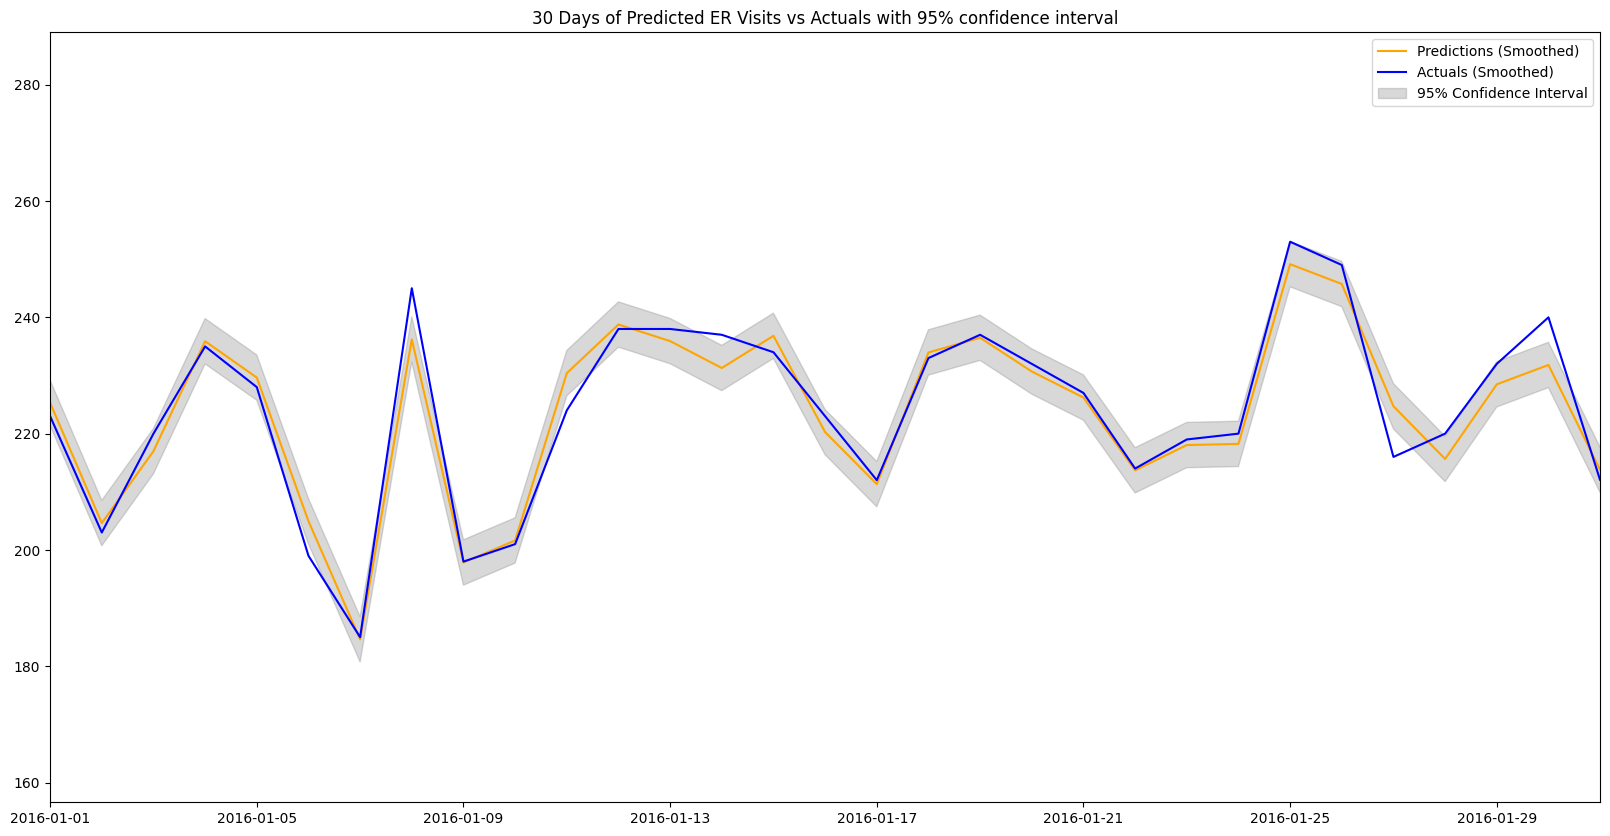

In [42]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = final_model.predict(X_test)

# Calculate rolling averages
window_size = 14  # 7-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - final_model.predict(X_train)

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(20,10))
plt.plot(y_test.index, preds_test, label='Predictions (Smoothed)', color='orange')
plt.plot(y_test.index, y_test, label='Actuals (Smoothed)', color='blue')
plt.fill_between(y_test.index, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
#limit window to 30 days
plt.xlim([y_test.index[0], y_test.index[30]])
plt.title('30 Days of Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()